In [8]:
# import random
# import numpy as np
# import pandas as pd
# from pathlib import Path

# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from PIL import Image
# from sklearn.model_selection import train_test_split

# # ─── Your constants ─────────────────────────────────────────────────────────────
# STEGO_CSV   = Path("csv/stego_final.csv")
# IMAGES_DIR  = Path("Images")
# BATCH_SIZE  = 16
# EPOCHS      = 15
# LR          = 1e-3
# RANDOM_SEED = 42

# # ─── Reproducibility ───────────────────────────────────────────────────────────
# random.seed(RANDOM_SEED)
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)

# # ─── 1) Build the unified DataFrame ───────────────────────────────────────────
# df_stego = pd.read_csv(STEGO_CSV)

# # keep only your two stego methods and label them
# df_stego = df_stego[df_stego.method.isin(["lsb", "iwt"])].copy()
# df_stego["binary_method"] = "stego"
# df_stego["img_path"]      = df_stego["stego_path"]

# # sample an equal number of covers (non-stego)
# n_stego     = len(df_stego)
# all_images  = list(IMAGES_DIR.glob("*"))
# used_names  = set(Path(p).name for p in df_stego["img_path"])
# candidates  = [str(p) for p in all_images if p.name not in used_names]
# none_samples = random.sample(candidates, min(n_stego, len(candidates)))

# df_none = pd.DataFrame({
#     "binary_method": ["none"] * len(none_samples),
#     "img_path":      none_samples
# })

# # combine & shuffle
# df = pd.concat([df_stego[["binary_method","img_path"]], df_none],
#                ignore_index=True)
# df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# print("Total dataset:", len(df), "    stego:", n_stego, "    none:", len(df_none))

# # ─── 2) Stratified splits ─────────────────────────────────────────────────────
# df_train, df_test = train_test_split(
#     df,
#     test_size=0.30,
#     stratify=df["binary_method"],
#     random_state=RANDOM_SEED
# )
# df_train, df_val  = train_test_split(
#     df_train,
#     test_size=0.20,
#     stratify=df_train["binary_method"],
#     random_state=RANDOM_SEED
# )

# print(f"Splits → train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")
# print("Train dist:\n", df_train["binary_method"].value_counts(normalize=True))
# print("Val   dist:\n", df_val["binary_method"].value_counts(normalize=True))
# print("Test  dist:\n", df_test["binary_method"].value_counts(normalize=True))


# # ─── 3) Dataset + DataLoaders ─────────────────────────────────────────────────
# label_map = {"none": 0, "stego": 1}

# train_transforms = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# val_transforms = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# class StegoDataset(Dataset):
#     def __init__(self, df, transforms=None):
#         self.df = df.reset_index(drop=True)
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row     = self.df.iloc[idx]
#         img_path= row["img_path"]
#         label   = label_map[row["binary_method"]]
#         image   = Image.open(img_path).convert("RGB")
#         if self.transforms:
#             image = self.transforms(image)
#         return image, label

# # instantiate
# train_ds = StegoDataset(df_train, transforms=train_transforms)
# val_ds   = StegoDataset(df_val,   transforms=val_transforms)
# test_ds  = StegoDataset(df_test,  transforms=val_transforms)

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
#                           num_workers=4, pin_memory=True)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
#                           num_workers=4, pin_memory=True)
# test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
#                           num_workers=4, pin_memory=True)

# print(f"Train batches: {len(train_loader)}")
# print(f"Val   batches: {len(val_loader)}")
# print(f"Test  batches: {len(test_loader)}")
# # 

Total dataset: 3794     stego: 1897     none: 1897
Splits → train: 2124, val: 531, test: 1139
Train dist:
 binary_method
none     0.5
stego    0.5
Name: proportion, dtype: float64
Val   dist:
 binary_method
stego    0.500942
none     0.499058
Name: proportion, dtype: float64
Test  dist:
 binary_method
none     0.500439
stego    0.499561
Name: proportion, dtype: float64
Train batches: 133
Val   batches: 34
Test  batches: 72


In [18]:
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ─── Constants ────────────────────────────────────────────────────────────────
STEGO_CSV   = Path("csv/stego_final.csv")
IMAGES_DIR  = Path("Images")
BATCH_SIZE  = 32
EPOCHS      = 15
LR          = 5e-4
RANDOM_SEED = 42

# ─── Reproducibility ─────────────────────────────────────────────────────────
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ─── 1) Build unified DataFrame ───────────────────────────────────────────────
df_stego = pd.read_csv(STEGO_CSV)
df_stego = df_stego[df_stego.method.isin(["lsb", "iwt"])].copy()
df_stego["binary_method"] = "stego"
df_stego["img_path"]      = df_stego["stego_path"]

n_stego     = len(df_stego)
all_images  = list(IMAGES_DIR.glob("*"))
used_names  = set(Path(p).name for p in df_stego["img_path"])
candidates  = [str(p) for p in all_images if p.name not in used_names]
none_samples= random.sample(candidates, min(n_stego, len(candidates)))

df_none = pd.DataFrame({
    "binary_method": ["none"] * len(none_samples),
    "img_path":      none_samples
})

df = pd.concat([df_stego[["binary_method","img_path"]], df_none],
               ignore_index=True)
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# ─── 2) Stratified splits ─────────────────────────────────────────────────────
df_train, df_test = train_test_split(
    df, test_size=0.20, stratify=df["binary_method"], random_state=RANDOM_SEED
)
df_train, df_val  = train_test_split(
    df_train, test_size=0.20, stratify=df_train["binary_method"], random_state=RANDOM_SEED
)

# ─── 3) Dataset & DataLoaders ────────────────────────────────────────────────
label_map = {"none": 0, "stego": 1}

train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

class StegoDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        img   = Image.open(row["img_path"]).convert("RGB")
        if self.transforms:
            img = self.transforms(img)
        label = label_map[row["binary_method"]]
        return img, label

train_ds = StegoDataset(df_train, transforms=train_transforms)
val_ds   = StegoDataset(df_val,   transforms=val_transforms)
test_ds  = StegoDataset(df_test,  transforms=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)

# ─── 4) Model ─────────────────────────────────────────────────────────────────
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
model     = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
# instead of model.fc = nn.Linear(...,2):
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(model.fc.in_features, 2)
)

model     = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# ─── 5) Train/Validate ────────────────────────────────────────────────────────
def train_epoch():
    model.train()
    loss_sum, correct, total = 0, 0, 0
    for imgs, lbls in tqdm(train_loader, desc="Train", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward(); optimizer.step()
        loss_sum += loss.item()*lbls.size(0)
        preds = out.argmax(1)
        correct += (preds==lbls).sum().item()
        total   += lbls.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def validate():
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    for imgs, lbls in tqdm(val_loader, desc="Val  ", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        out  = model(imgs)
        loss = criterion(out, lbls)
        loss_sum += loss.item()*lbls.size(0)
        preds    = out.argmax(1)
        correct  += (preds==lbls).sum().item()
        total    += lbls.size(0)
    return loss_sum/total, correct/total

best_acc = 0.0
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch()
    val_loss, val_acc= validate()
    scheduler.step()
    print(f"Epoch {epoch}/{EPOCHS}: "
          f"Train loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"Val   loss={val_loss:.4f}, acc={val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_stego_resnet18.pth")
        print(f" → New best: {best_acc:.4f}")
print("Done. Best val acc:", best_acc)


Using cache found in /home/nitinjha/.cache/torch/hub/pytorch_vision_main
/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15: Train loss=0.5989, acc=0.6936 | Val   loss=0.5182, acc=0.7298
 → New best: 0.7298


Epoch 2/15: Train loss=0.5029, acc=0.7311 | Val   loss=0.5182, acc=0.7298


Epoch 3/15: Train loss=0.5205, acc=0.7265 | Val   loss=0.5264, acc=0.7315
 → New best: 0.7315


Epoch 4/15: Train loss=0.5067, acc=0.7290 | Val   loss=0.5942, acc=0.7150


Epoch 5/15: Train loss=0.4941, acc=0.7294 | Val   loss=0.5419, acc=0.7315


Epoch 6/15: Train loss=0.4788, acc=0.7418 | Val   loss=0.5242, acc=0.7216


Epoch 7/15: Train loss=0.4700, acc=0.7508 | Val   loss=0.5307, acc=0.7282


Epoch 8/15: Train loss=0.4594, acc=0.7545 | Val   loss=0.5595, acc=0.6919


Epoch 9/15: Train loss=0.4508, acc=0.7570 | Val   loss=0.5629, acc=0.7018


Epoch 10/15: Train loss=0.4411, acc=0.7677 | Val   loss=0.5974, acc=0.6771


Epoch 11/15: Train loss=0.4116, acc=0.7920 | Val   loss=0.6019, acc=0.6738


Epoch 12/15: Train loss=0.4073, acc=0.7838 | Val   loss=0.6102, acc=0.6689


Epoch 13/15: Train loss=0.4057, acc=0.7941 | Val   loss=0.6200, acc=0.6771


Epoch 14/15: Train loss=0.4007, acc=0.7916 | Val   loss=0.6396, acc=0.6771


Epoch 15/15: Train loss=0.4006, acc=0.7937 | Val   loss=0.6363, acc=0.6705
Done. Best val acc: 0.7314662273476112


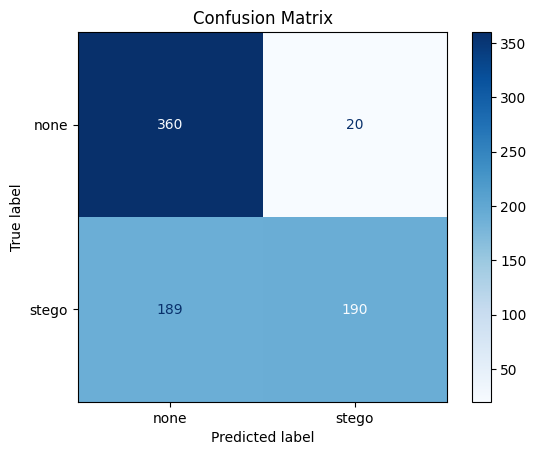

              precision    recall  f1-score   support

        none       0.66      0.95      0.78       380
       stego       0.90      0.50      0.65       379

    accuracy                           0.72       759
   macro avg       0.78      0.72      0.71       759
weighted avg       0.78      0.72      0.71       759



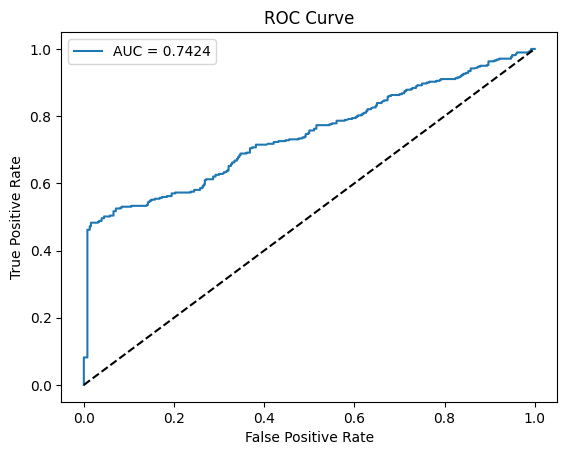

In [19]:
#FOR LR =5E-4 with L2 regularization +0.3 dropoout
import torch
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. Load best model
model.load_state_dict(torch.load("best_stego_resnet18.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
        preds = out .argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)



# 3. Precision/Recall/F1
print(classification_report(all_labels, all_preds, target_names=['none','stego']))

# 4. ROC curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score   = roc_auc_score(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


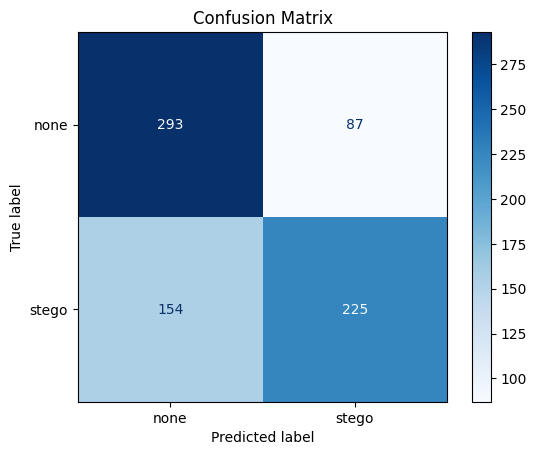

              precision    recall  f1-score   support

        none       0.66      0.77      0.71       380
       stego       0.72      0.59      0.65       379

    accuracy                           0.68       759
   macro avg       0.69      0.68      0.68       759
weighted avg       0.69      0.68      0.68       759



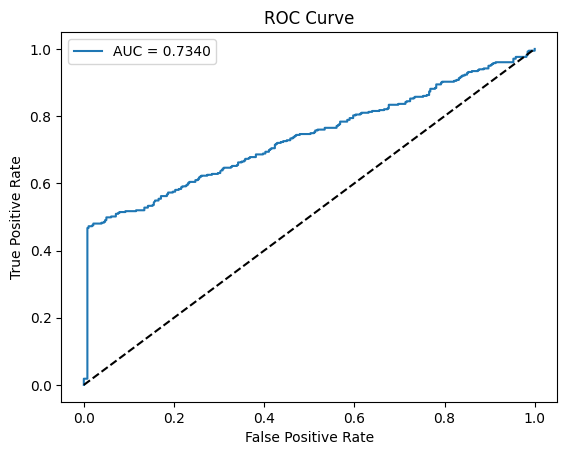

In [17]:
#FOR LR =5E-5 with L2 regularization
import torch
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. Load best model
model.load_state_dict(torch.load("best_stego_resnet18.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
        preds = out .argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

# 2. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['none','stego'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 3. Precision/Recall/F1
print(classification_report(all_labels, all_preds, target_names=['none','stego']))

# 4. ROC curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score   = roc_auc_score(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


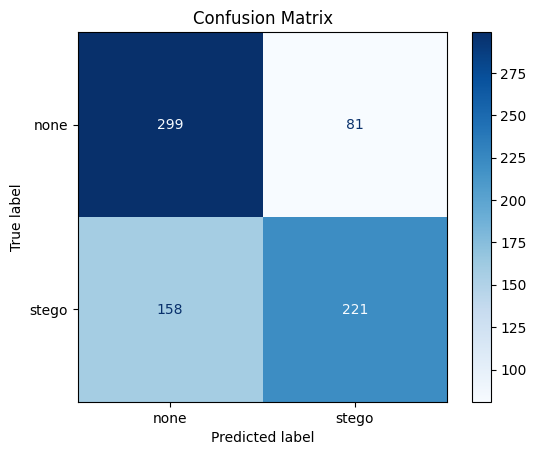

              precision    recall  f1-score   support

        none       0.65      0.79      0.71       380
       stego       0.73      0.58      0.65       379

    accuracy                           0.69       759
   macro avg       0.69      0.68      0.68       759
weighted avg       0.69      0.69      0.68       759



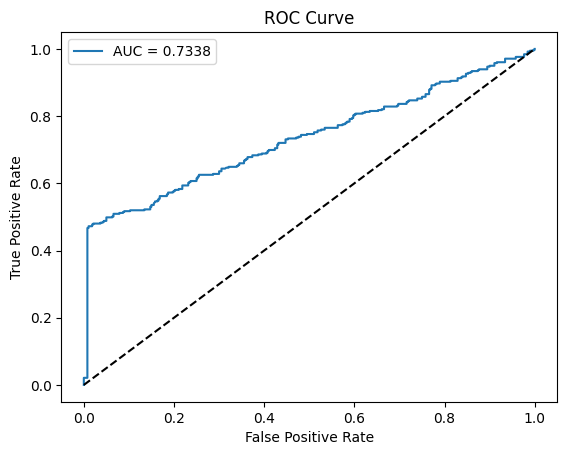

In [15]:
#FOR LR =5E-5
import torch
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. Load best model
model.load_state_dict(torch.load("best_stego_resnet18.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
        preds = out .argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

# 2. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['none','stego'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 3. Precision/Recall/F1
print(classification_report(all_labels, all_preds, target_names=['none','stego']))

# 4. ROC curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score   = roc_auc_score(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


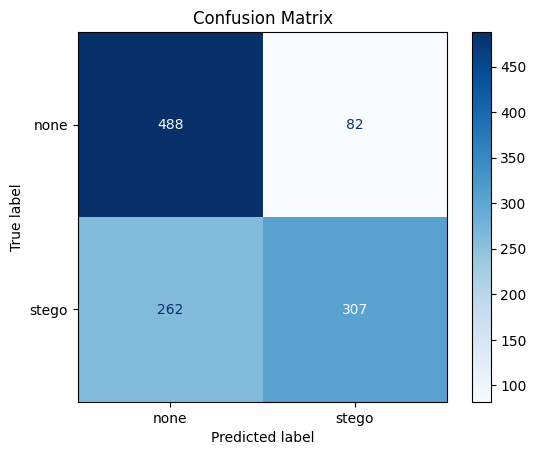

              precision    recall  f1-score   support

        none       0.65      0.86      0.74       570
       stego       0.79      0.54      0.64       569

    accuracy                           0.70      1139
   macro avg       0.72      0.70      0.69      1139
weighted avg       0.72      0.70      0.69      1139



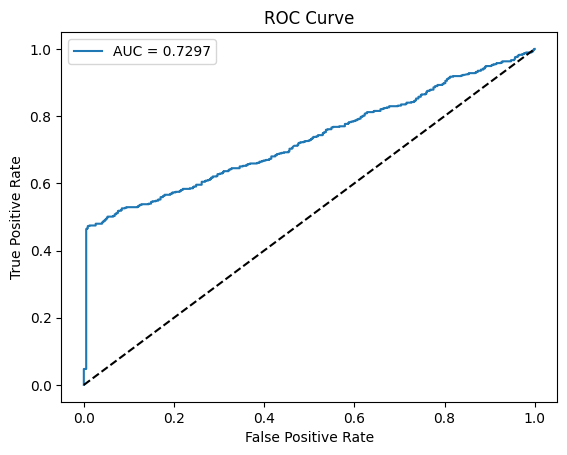

In [13]:
#FOR LR =1E-4
import torch
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. Load best model
model.load_state_dict(torch.load("best_stego_resnet18.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
        preds = out .argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

# 2. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['none','stego'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 3. Precision/Recall/F1
print(classification_report(all_labels, all_preds, target_names=['none','stego']))

# 4. ROC curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score   = roc_auc_score(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


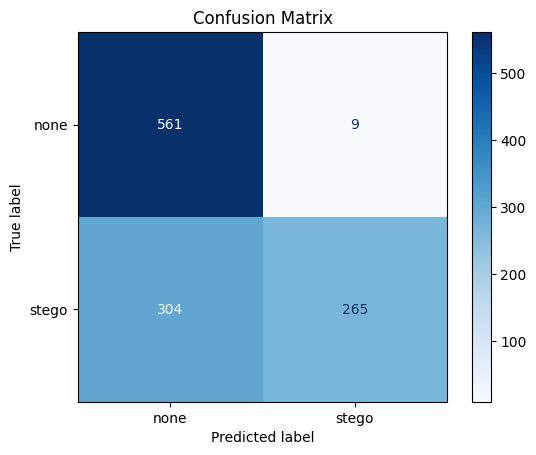

              precision    recall  f1-score   support

        none       0.65      0.98      0.78       570
       stego       0.97      0.47      0.63       569

    accuracy                           0.73      1139
   macro avg       0.81      0.72      0.71      1139
weighted avg       0.81      0.73      0.71      1139



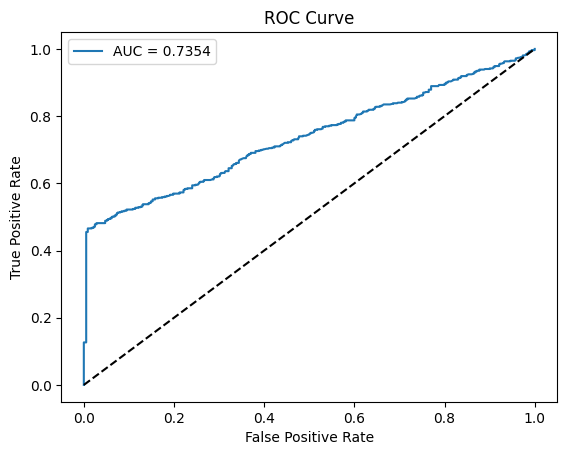

In [11]:

#FOR LR=1E-3

import torch
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. Load best model
model.load_state_dict(torch.load("best_stego_resnet18.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
        preds = out .argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

# 2. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['none','stego'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 3. Precision/Recall/F1
print(classification_report(all_labels, all_preds, target_names=['none','stego']))

# 4. ROC curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score   = roc_auc_score(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
